### General EOS Noh problem

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate

#### Ideal gas: K -> 0 "classical Noh" axisymmetric

In [2]:
rho_inf = 1.2
p_inf = 0.1
gamma = 1.4

Testing one ODE solve...
Last xU: -1.0000007396656831
u_inf:   300.00022189970497


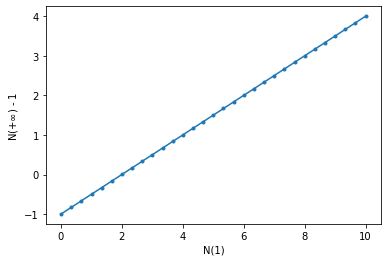

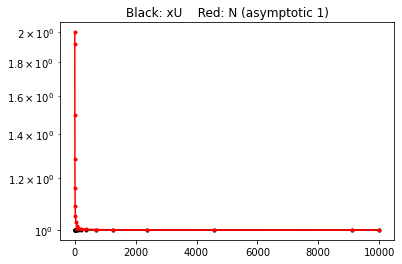

In [3]:
def RHS(x, q, us):
  ''' ODE RHS with 
    q = [U, N],
  and Aq' = b(q) from
    (U-1) (U+xU') + K/(rho_inf*us**2) * N' / (N*N) == 0 # Momentum
    (U-1) x N' / N + 2U + xU' == 0.                     # Mass
  Here x is the similarity variable.
  '''
  U, N = q
  
  # Ideal gas bulk modulus
  rho = N * rho_inf
  K = gamma * p_inf * (rho / rho_inf) ** gamma
  # Compute inv(A) @ b
  A = np.array([[(U-1)*x, K/(rho_inf*us**2) / (N*N)], [x, (U-1) * x / N]])
  b = np.array([(1-U)*U,-2*U])
  _detA = A[1,1] * A[0,0] - A[1,0] * A[0, 1]
  x = np.zeros_like(b)
  x[0] = (A[1,1] * b[0] - A[0,1] * b[1]) / _detA
  x[1] = (-A[1,0] * b[0] + A[0,0] * b[1]) / _detA
  return x

def solve_outer(q0, us):
  ''' Return solution object for outer solution '''
  return scipy.integrate.solve_ivp(lambda x, q: RHS(x, q, us), [1, 10_000], q0)

# Solve infinity boundary condition residual
def inf_residual(U, N, us):
  ''' Solve outer problem and return infinity BC residual (N - 1)'''
  out = solve_outer(np.array([U, N]), us)
  return out.y[1,-1] - 1

''' Compute N(x=1) that satisfies infinity boundary condition '''
def match_infty_N_BC(U0, us):
  rootf_soln = scipy.optimize.root_scalar(lambda N: inf_residual(U0, N, us),
                                          bracket=[1e-5, 1e5], method='brenth')
  if not rootf_soln.converged:
    raise ValueError(f"Could not converge root-finding for N(1). Dumping "
                     + f"returned solution from root_scalar.\n{rootf_soln}")
  return rootf_soln

# Try test values
U0 = -1.0
us = 300
# Generate test plot for residual as a function of N (want root of residual)
_test_N_vector = np.linspace(0.01, 10, 31)
_test_residual_vector = [inf_residual(U0, N, us) for N in _test_N_vector]
plt.plot(_test_N_vector, _test_residual_vector, '.-')
plt.ylabel("N($+\infty$) - 1")
plt.xlabel("N(1)")

''' Compute outer solution. '''
rootf_soln = match_infty_N_BC(U0, us)
N0 = rootf_soln.root
q0 = np.array([U0, N0])
# Solve outer solution
out = solve_outer(q0, us)
# Extract u_inf from asymptotic value
u_inf = -us * (out.t[-1] * out.y[0,-1])

# Plot outer solution with initial guess for interface (U, N)
plt.figure()
plt.semilogy(out.t, -out.t * out.y[0,:], 'k.-')
plt.plot(out.t, out.y[1,:], 'r.-')
plt.plot(out.t, np.ones_like(out.t), 'r--')
plt.title("Black: xU    Red: N (asymptotic 1)")
print("Testing one ODE solve...")
print(f"Last xU: {out.t[-1] * out.y[0,-1]}")
print(f"u_inf:   {u_inf}")

In [4]:
def compute_shock_velocity_gamma_gas(q, us, full_output:bool=False):
  ''' Using q == (U, N), compute the shock velocity satisfiying RH.
  Mass is used to compute density.
  Hugoniot (mixed mass-momentum-energy) is used to compute pressure.
  Momentum is used to compute shock velocity. '''

  Uplus, Nplus = q
  # Compute dimensional quantities on either side of the shock
  Nminus = Nplus * (1 - Uplus)
  rhominus = rho_inf * Nminus
  rhoplus  = rho_inf * Nplus
  vminus = 1.0 / rhominus
  vplus = 1.0 / rhoplus
  uminus = 0
  uplus = Uplus * us
  pplus = p_inf * (rhoplus / rho_inf) ** gamma
  # Compute post-shock pressure from Hugoniot:
  # (pminus * vminus + pplus * vplus)
  #   + 0.5 * (gamma-1) (pminus + pplus)(vminus - vplus) == 0
  _num = -0.5 * (gamma-1) * (vminus - vplus) * pplus + pplus * vplus
  _den = vminus + 0.5 * (gamma-1) * (vminus - vplus)
  pminus = _num / _den,
  # Output shock velocity from momentum condition
  us_out = (pplus - pminus) / (rhominus * uplus)
  if full_output:
    return us_out, {
      "pminus": pminus,
      "pplus": pplus,
      "rhominus": rhominus,
      "rhoplus": rhoplus,
    }
  return float(us_out)

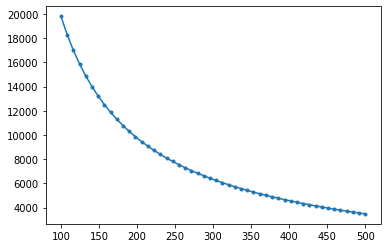

In [6]:
''' Map Hugoniot residual for fixed U0 '''
U0 = -2/(gamma-1)+1e-7#-1

# Hugoniot residual
def compute_hugoniot_residual(U0, us):
  rootf_soln = match_infty_N_BC(U0, us)
  N0 = rootf_soln.root
  us_hugoniot = compute_shock_velocity_gamma_gas(np.array([U0, N0]), us)
  return us_hugoniot - us

test_us_vector = np.linspace(100, 500 ,50)
test_hres_vector = [compute_hugoniot_residual(U0, us) for us in test_us_vector]
plt.plot(test_us_vector, test_hres_vector, '.-')

In [7]:
''' Use visual curve for initial guess to iterative solver for Hugoniot residual. '''
us_soln = scipy.optimize.root_scalar(lambda us: compute_hugoniot_residual(U0, us),
                                     x0=100, x1=110, method='secant')
us_soln

      converged: True
           flag: 'converged'
 function_calls: 17
     iterations: 16
           root: 1410.8134981183637

u_inf: 300.00022189970497
u_s:   1410.8134981183637
U, N compared to asymptotic (K = 0) strong shock solution


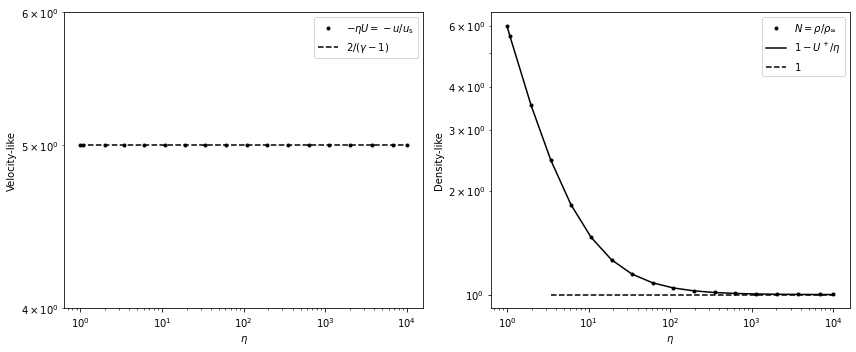

In [8]:
''' Compare to strong-shock limit '''
rootf_soln = match_infty_N_BC(U0, us_soln.root)
N0 = rootf_soln.root
out = solve_outer(np.array([U0, N0]), us_soln.root)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
# plt.semilogy(out.t, -out.y[0,:], 'k.-')
plt.loglog(out.t, -out.t * out.y[0,:], 'k.')
plt.ylim(4,6)
plt.plot(out.t, 2/(gamma-1)* np.ones_like(out.t), 'k--')
plt.legend(["$-\eta U = -u/u_\mathrm{s}$",
            "$2/(\gamma - 1)$",])
plt.xlabel("$\eta$")
plt.ylabel("Velocity-like")

print(f"u_inf: {u_inf}")
print(f"u_s:   {us_soln.root}")

plt.subplot(1,2,2)
# plt.loglog(out.t, (1 + u_inf/out.t/us_soln.root)**1, '.-')
plt.loglog(out.t, (1 - U0/out.t)**1, 'k.')
plt.loglog(out.t, out.y[1,:], 'k-')
plt.plot(out.t[3:], np.ones_like(out.t[3:]), 'k--')
plt.legend([r"$N = \rho / \rho_{\infty}$",
            "$1 - U^+ / \eta$",
            "$1$"])
plt.xlabel("$\eta$")
plt.ylabel("Density-like")
plt.tight_layout()
print("U, N compared to asymptotic (K = 0) strong shock solution")

U, N compared to asymptotic (K = 0) strong shock solution


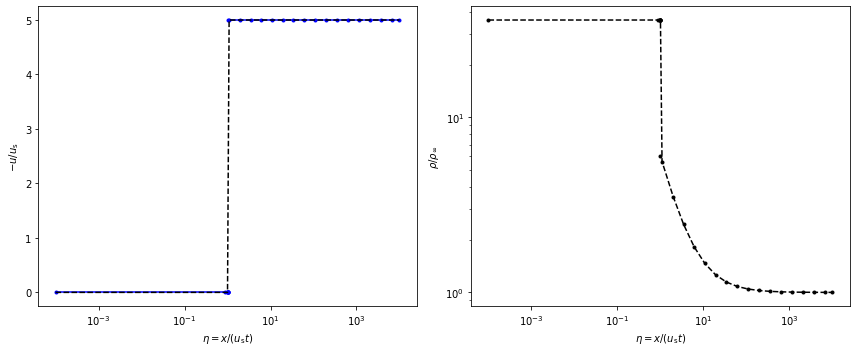

In [9]:
''' Solve interior solution '''

Uminus = 0
Nminus = rootf_soln.root * (1 - U0)
qminus = np.array([Uminus, Nminus])
# Solve interior solution numerically
soln_interior = scipy.integrate.solve_ivp(lambda x, q: RHS(x, q, us_soln.root), [1, 1e-4], qminus)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
# Exterior solution for -u/u_s
plt.semilogx(out.t, -out.t * out.y[0,:], 'b.-')
# Interior solution for -u/u_s
plt.semilogx(soln_interior.t, -soln_interior.t * soln_interior.y[0,:], 'b.-')
# Infinite strength shock limit solution
asymptotic_t = np.unique([*soln_interior.t, *out.t])
asymptotic_u = np.where(asymptotic_t <= 1, 
                        np.zeros_like(asymptotic_t),
                        2/(gamma-1))
# Exterior asymptote
plt.plot(asymptotic_t, asymptotic_u, 'k--')
# Add labels
plt.xlabel("$\eta = x/(u_\mathrm{s} t)$")
plt.ylabel("$-u/u_\mathrm{s}$")

plt.subplot(1,2,2)
# Exterior solution for rho/rho_infty
plt.loglog(out.t, (1 - U0/out.t), 'k.')
# Interior solution
plt.plot(soln_interior.t, soln_interior.y[1,:], 'k.')
# Infinite strength shock limit solution
asymptotic_t = np.unique([*soln_interior.t, *out.t])
asymptotic_rho = np.where(asymptotic_t <= 1, 
                          (1 - U0) ** 2,
                          1 - U0/asymptotic_t)
# Exterior asymptote
plt.plot(asymptotic_t, asymptotic_rho, 'k--')
# plt.plot(out.t[3:], np.ones_like(out.t[3:]), 'k--')
# plt.legend([r"$N = \rho / \rho_{\infty}$",
            # "$1 - U^+ / \eta$",
            # "$1$"])
# plt.ylim(30, 40)
# Add labels
plt.xlabel("$\eta = x/(u_\mathrm{s} t)$")
plt.ylabel(r"$\rho/\rho_{\infty}$")
plt.tight_layout()
print("U, N compared to asymptotic (K = 0) strong shock solution")

In [10]:
''' Report compression ratios '''
# Extract pressure ratio
_, shocked_dict = compute_shock_velocity_gamma_gas(
  np.array([U0, rootf_soln.root]), us_soln.root, full_output=True)
pminus = shocked_dict["pminus"][0]
pplus = shocked_dict["pplus"]

# Ideal p jump - shock speed relation from Rankine Hugoniot
pjump_ideal = 2 * rho_inf / (gamma-1) * (gamma+1)**2 / (gamma-1)**2 * us_soln.root**2
pminus, pjump_ideal

Nratio = Nminus / rootf_soln.root
print(f"Density compression ratio: {Nratio:e}")
print(f"Pressure jump, numerical ODE: {pminus - pplus:e}")
print(f"Pressure jump for infinite strength shock, with infinite shock speed is infinite.")
print(f"Pressure jump for infinite strength shock, with numerical shock speed: {pjump_ideal:e}")
print(f"Pressure ratio, numerical ODE: {pminus / pplus:e}")
print(f"Pressure ratio for infinite strength shock is infinite.")

Density compression ratio: 6.000000e+00
Pressure jump, numerical ODE: 4.297104e+08
Pressure jump for infinite strength shock, with infinite shock speed is infinite.
Pressure jump for infinite strength shock, with numerical shock speed: 4.299253e+08
Pressure ratio, numerical ODE: 3.500000e+08
Pressure ratio for infinite strength shock is infinite.
